In [3]:

### Required libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns
import cv2
# from osgeo import gdal
import colorsys
from PIL import Image
from scipy import misc
from skimage import io
from spectral import get_rgb
from spectral import ndvi
from sklearn import preprocessing

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


In [4]:
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'
print(test_path1)

test_jpg/


total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365 

There is 17 unique labels including {'blow_down', 'agriculture', 'partly_cloudy', 'habitation', 'bare_ground', 'haze', 'cultivation', 'cloudy', 'clear', 'blooming', 'artisinal_mine', 'water', 'road', 'primary', 'conventional_mine', 'slash_burn', 'selective_logging'} 



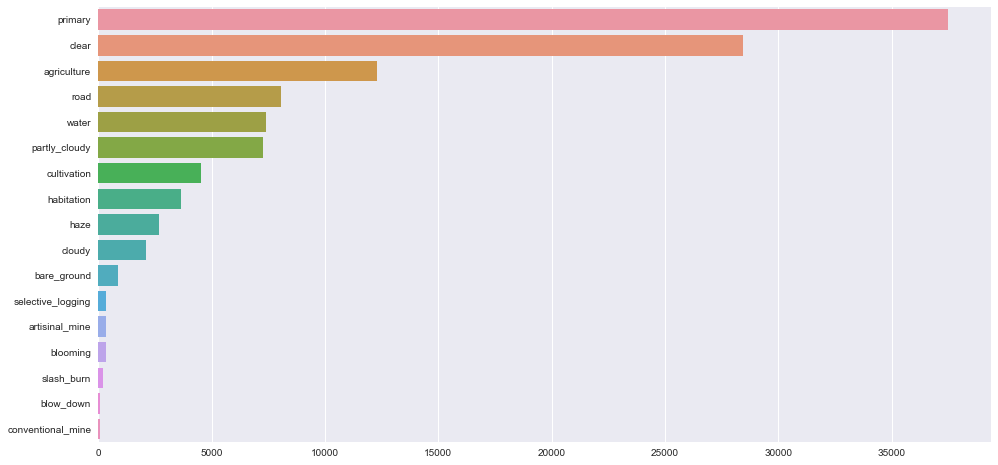

In [5]:
df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]

# from collections import Counter

# counts = Counter(df['tags'])
# df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
# df_counts = df_counts.rename(columns={'index':'label', 0:'count'})


# print(df_counts.sort_values(by=['count'], ascending=False))
# print(df_counts[df_counts ['count']< 5.0 ].count())


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {} \n'.format(1.0*len(all_tags)/df.shape[0]))

labels_set = set(all_tags)
print("There is {} unique labels including {} \n".format(len(labels_set), labels_set))

# Histogram of label instances# Histo 
labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

# tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
# tags_counted_and_sorted.head()
# tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

In [4]:
image_paths = sorted(os.listdir(train_path1))[0:1000]

image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

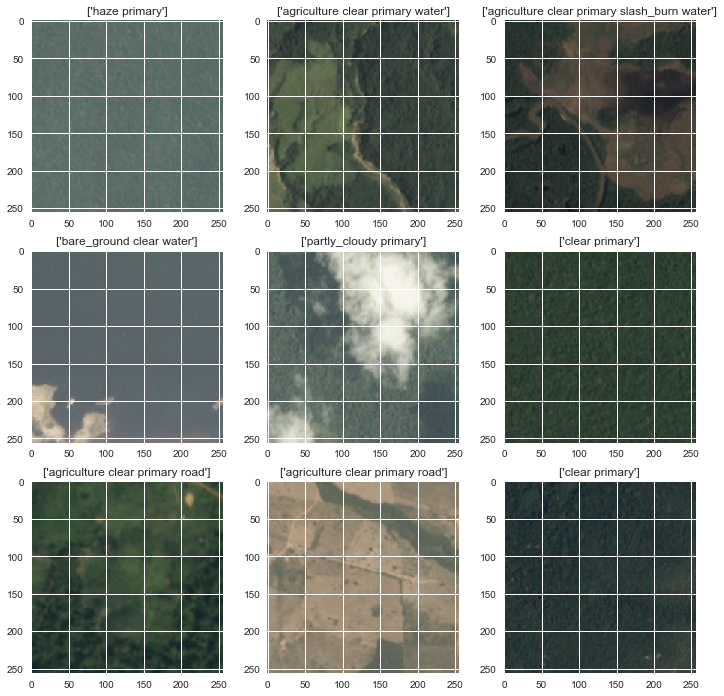

In [5]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    path2='train_jpg/'
    plt.imshow(plt.imread(path2+str(image_paths[i])))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

In [6]:
np.seterr(all='warn')
def veg_and_water(image_str):
    tif_img = io.imread(train_path2+image_str)
    RGB= get_rgb(tif_img, [2, 1, 0]) # RGB
    IRRG = get_rgb(tif_img, [3, 2, 1]) # NIR-R-G
    IRRB = get_rgb(tif_img, [3, 2, 0]) # NIR-R-Bs
    #this predicts likelihood of a tree being there
    veg_np = (IRRG[:, :, 0] - IRRG[:, :, 1]) / (IRRG[:, :, 0] + IRRG[:, :, 1]) # (NIR - RED) / (NIR + RED)
    #this predicts likelihood of waters
    water_np = (IRRB[:, :, 2] - IRRB[:, :, 0]) / (IRRB[:, :, 2] + IRRB[:, :, 0]) #
    return [veg_np,water_np]

# image_paths = sorted(os.listdir(train_path2))

extracted_features=[]

for i in range(1000):
    extracted_features.append(veg_and_water("train_"+str(i)+".tif"))
print(extracted_features)   

C:\Users\Elle\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Elle\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in true_divide


[[array([[ 0.10521961,  0.15521863,  0.09297559, ..., -0.0989066 ,
        -0.19136193, -0.02380335],
       [ 0.04214414,  0.0238075 ,  0.10303268, ..., -0.01413678,
         0.14120653,  0.03911694],
       [-0.10687016,  0.01401307,  0.07753109, ...,  0.07881685,
         0.14607918,  0.18844079],
       ..., 
       [ 0.00922692,  0.2023127 ,  0.16121759, ...,  0.27329335,
         0.17769438,  0.16532818],
       [ 0.04278835,  0.08787679, -0.02342298, ...,  0.15096111,
         0.01209031,  0.01201843],
       [ 0.02697037,  0.07670203, -0.07020444, ...,  0.35584188,
         0.08979083,  0.06244863]]), array([[-0.09148139, -0.20550645, -0.13466387, ...,  0.05394263,
         0.2099341 ,  0.02811672],
       [-0.096153  , -0.17479877, -0.17310902, ..., -0.1837701 ,
        -0.22577907,  0.01195054],
       [ 0.06026187, -0.09103611, -0.20700637, ..., -0.16866187,
        -0.42163714, -0.25569438],
       ..., 
       [ 0.01397779, -0.25597745, -0.12486752, ..., -0.33606482,
     

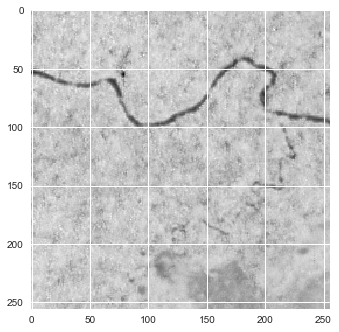

In [7]:
##show the water body works
plt.imshow(extracted_features[75][1])


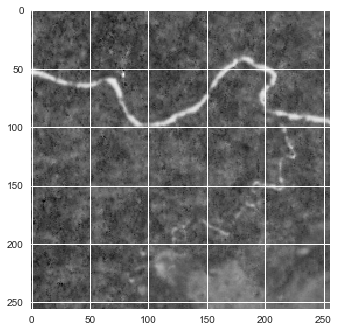

In [7]:
#### show the veg body works
plt.imshow(extracted_features[75][0])

In [6]:

## haze - remover - this only works on JPGs - possibly can be used to remove haze

import math
def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz,1);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
        atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]

    return res


def remove_haze(image):
    src = cv2.imread("train_jpg/train_40378.jpg");

    I = src.astype('float64')/255;
 
    dark = DarkChannel(I,15);
    A = AtmLight(I,dark);
    te = TransmissionEstimate(I,A,15);
    t = TransmissionRefine(src,te);
    J = Recover(I,t,A,0.1);

    cv2.imshow("dark",dark);
    cv2.imshow("t",t);
    cv2.imshow('I',src);
    cv2.imshow('J',J);
    cv2.imwrite("./image/J.jpg",J*255);
    cv2.waitKey();
# remove_haze()


In [7]:
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)


df_tags = df['weather'].tolist()

test_labels=df_tags[4000:5000]
train_labels=df_tags[:4000]

In [8]:
weather_jpgs=[]
def read_image(image_str):
    jpg_img = io.imread(train_path1+image_str)
    norm_img=jpg_img/255
    return norm_img.flatten()
for i in range(5000):
    weather_jpgs.append(read_image("train_"+str(i)+".jpg"))


In [21]:
print( weather_jpgs[0].shape)
# weather_jpg=np.asarray(weather_jpgs)


(196608,)


In [9]:
train_data=weather_jpgs[:4000]
test_data=weather_jpgs[4000:5000]

In [ ]:
model_MNB =LogisticRegression()
model_MNB.fit(train_data, train_labels)
dev_predictions2=model_MNB.predict(test_data)
print(classification_report(test_labels,dev_predictions2))

In [ ]:
def k_model(k,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = KNeighborsClassifier(n_neighbors=k)
    #fit per the train data
    model.fit(data_train, labels_train)
    #set by the test data
    score = model.score(data_test, labels_test)
    #print the score prettily
    return (str(k)+"-NN model score: "+	str("{:.2%}".format(score)))

k_values = [1, 3]

#print eveyrhting
print("dev data sets")
for k in k_values:
    print(k_model(k,train_data,train_labels,test_data,test_labels))